<a href="https://colab.research.google.com/github/mehrshad-sdtn/BSc-Thesis-Project/blob/master/notebooks/explained_cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import glob
import pathlib
import PIL, PIL.Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from skimage.segmentation import mark_boundaries
import random

In [2]:
base_dir = '/content/drive/MyDrive'
data_dir = os.path.join(base_dir, 'BSc_Project', 'out')
a_dataset = pathlib.Path(os.path.join(data_dir, 'A'))
models_path = os.path.join(base_dir, 'BSc_Project', 'models')

In [3]:
batch = 128
img_height = 224
img_width = 224

In [4]:
classes = os.listdir(a_dataset)
print(f"classes: {classes}")

classes: ['sch', 'norm']


In [5]:
def load_image(filepath, dims):
   image = cv2.cvtColor(
      cv2.imread(filepath), cv2.COLOR_BGR2RGB)
   image = cv2.resize(image, dims)
   image = image.astype('float32') / 255.0
   return image


def image_arrays_from_directory(directory):
  arrays = []
  counter = 0
  for i, cat in enumerate(os.listdir(directory)):
    path = os.path.join(directory, cat)
    for image in os.listdir(path):
      counter += 1
      image = load_image(os.path.join(path, image), dims=(img_height, img_width))
      arrays.append((image, 1 - i))
  print(f"{counter} images were read")
  return arrays


def train_validation_split(data_array, ratio):
  length = int(ratio * len(data_array))
  return data_array[length:], data_array[:length]

In [6]:
dataset_images = image_arrays_from_directory(a_dataset)
print(dataset_images[0])
print(dataset_images[0][0].max(), dataset_images[0][0].min())

948 images were read
(array([[[0.12156863, 0.5764706 , 0.54509807],
        [0.12156863, 0.5764706 , 0.54509807],
        [0.12156863, 0.5764706 , 0.54509807],
        ...,
        [0.12156863, 0.5764706 , 0.54509807],
        [0.12156863, 0.5764706 , 0.54509807],
        [0.12156863, 0.5764706 , 0.54509807]],

       [[0.13333334, 0.5372549 , 0.5529412 ],
        [0.13333334, 0.5372549 , 0.5529412 ],
        [0.13333334, 0.5372549 , 0.5529412 ],
        ...,
        [0.11764706, 0.6156863 , 0.53333336],
        [0.11764706, 0.6156863 , 0.53333336],
        [0.11764706, 0.6156863 , 0.53333336]],

       [[0.11764706, 0.6156863 , 0.53333336],
        [0.11764706, 0.6156863 , 0.53333336],
        [0.11764706, 0.6156863 , 0.53333336],
        ...,
        [0.1254902 , 0.5686275 , 0.54901963],
        [0.1254902 , 0.5686275 , 0.54901963],
        [0.1254902 , 0.5686275 , 0.54901963]],

       ...,

       [[0.92941177, 0.8980392 , 0.10588235],
        [0.92941177, 0.8980392 , 0.10588235],


In [7]:
random.seed(123)
random.shuffle(dataset_images)
train, validation = train_validation_split(dataset_images, ratio=0.2)

In [8]:
len(train), len(validation)

(759, 189)

In [9]:
def seperate_lebale(paired_data):
  X = np.array([data for data, label in paired_data])
  y = np.array([label for data, label in paired_data])
  return X, y


X_train, y_train = seperate_lebale(train)
X_valid, y_valid = seperate_lebale(validation)

In [10]:
X_train.shape, y_train.shape

((759, 224, 224, 3), (759,))

In [11]:
X_valid.shape, y_valid.shape

((189, 224, 224, 3), (189,))

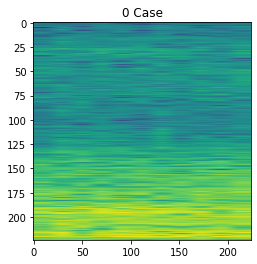

In [12]:
i = random.randrange(0, 100)
### 0: normal, 1: schizophrenia
plt.title(f"{y_train[i]} Case")
plt.imshow(X_train[i])
plt.show()

In [13]:
def plot_learning_curves(history, arg):
  plt.figure(dpi=100)
  plt.plot(history.history[f'{arg}'])
  plt.plot(history.history[f'val_{arg}'])
  plt.legend(["train", "validation"], loc=0)
  plt.ylabel(f'{arg}')
  plt.xlabel('epochs')
  plt.show()

####**CNN classification with a simple model**

In [14]:
tf.random.set_seed(123)
np.random.seed(123)

num_classes = 2

simple_model = tf.keras.Sequential([
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, activation='relu'),
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(512, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])


In [15]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
simple_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


simple_history = simple_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=batch, shuffle=False)

Epoch 1/100
6/6 [==============================] - 26s 2s/step - loss: 0.6934 - accuracy: 0.4888 - val_loss: 0.6904 - val_accuracy: 0.5767
Epoch 2/100
6/6 [==============================] - 3s 433ms/step - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6864 - val_accuracy: 0.5767
Epoch 3/100
6/6 [==============================] - 3s 433ms/step - loss: 0.6899 - accuracy: 0.5204 - val_loss: 0.6813 - val_accuracy: 0.5767
Epoch 4/100
6/6 [==============================] - 3s 434ms/step - loss: 0.6839 - accuracy: 0.5204 - val_loss: 0.6701 - val_accuracy: 0.5820
Epoch 5/100
6/6 [==============================] - 3s 435ms/step - loss: 0.6643 - accuracy: 0.6153 - val_loss: 0.6434 - val_accuracy: 0.6720
Epoch 6/100
6/6 [==============================] - 3s 435ms/step - loss: 0.6207 - accuracy: 0.7009 - val_loss: 0.6161 - val_accuracy: 0.6032
Epoch 7/100
6/6 [==============================] - 3s 438ms/step - loss: 0.5757 - accuracy: 0.6930 - val_loss: 0.6064 - val_accuracy: 0.5979
Epoch 8/100
6/6

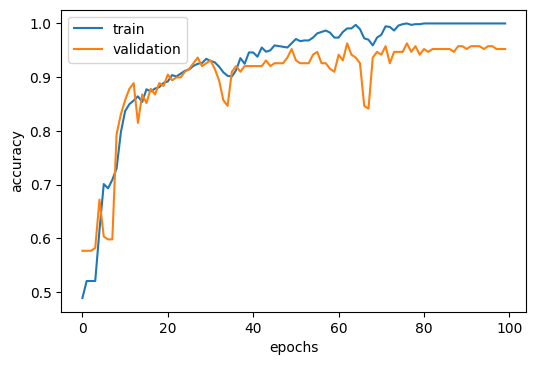

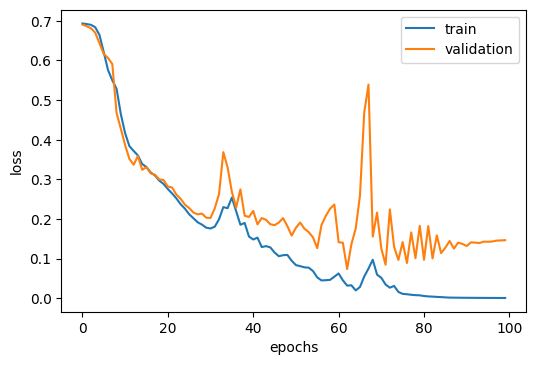

In [16]:
plot_learning_curves(simple_history, 'accuracy')
plot_learning_curves(simple_history, 'loss')

####**CNN classification with a VGG-16 model**

In [17]:
tf.random.set_seed(123)
np.random.seed(123)

num_classes = 2

vgg16_model = keras.Sequential()
vgg16_model.add(layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg16_model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
vgg16_model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(4096,activation="relu"))
vgg16_model.add(layers.Dense(num_classes, activation="softmax"))
vgg16_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
vgg16_model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

vgg_history = vgg16_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=70, batch_size=batch, shuffle=False)

Epoch 1/70
6/6 [==============================] - 63s 7s/step - loss: 0.6935 - accuracy: 0.5072 - val_loss: 0.6902 - val_accuracy: 0.5767
Epoch 2/70
6/6 [==============================] - 12s 2s/step - loss: 0.6927 - accuracy: 0.5204 - val_loss: 0.6880 - val_accuracy: 0.5767
Epoch 3/70
6/6 [==============================] - 12s 2s/step - loss: 0.6914 - accuracy: 0.5204 - val_loss: 0.6813 - val_accuracy: 0.5767
Epoch 4/70
6/6 [==============================] - 12s 2s/step - loss: 0.6861 - accuracy: 0.5204 - val_loss: 0.6607 - val_accuracy: 0.5767
Epoch 5/70
6/6 [==============================] - 12s 2s/step - loss: 0.7916 - accuracy: 0.5863 - val_loss: 0.6140 - val_accuracy: 0.6455
Epoch 6/70
6/6 [==============================] - 12s 2s/step - loss: 0.6785 - accuracy: 0.5323 - val_loss: 0.6938 - val_accuracy: 0.4286
Epoch 7/70
6/6 [==============================] - 12s 2s/step - loss: 0.6926 - accuracy: 0.5375 - val_loss: 0.6886 - val_accuracy: 0.5767
Epoch 8/70
6/6 [==================

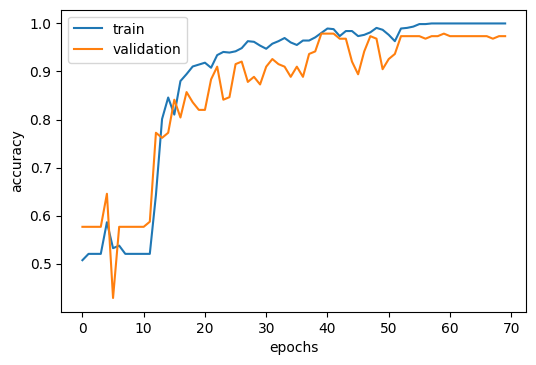

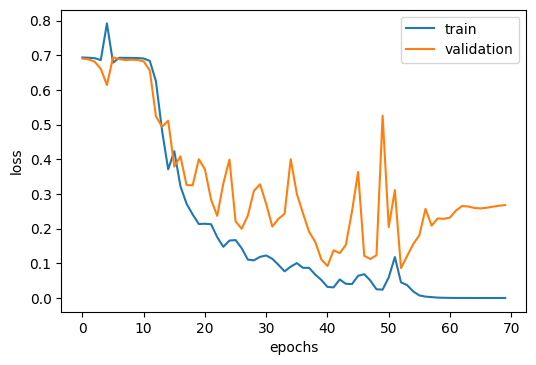

In [19]:
plot_learning_curves(vgg_history, 'accuracy')
plot_learning_curves(vgg_history, 'loss')

In [23]:
simple_model.save(os.path.join(models_path, 'simple_model_final.h5'))

In [22]:
vgg16_model.save(os.path.join(models_path, 'vgg16_model_final.h5'))

use `model = keras.models.load_model('path/to/location')` to load the models

In [14]:
models_path = os.path.join(base_dir, 'BSc_Project', 'models')
simple_model = keras.models.load_model(os.path.join(models_path, 'simple_model_final.h5')) 
vgg16_model = keras.models.load_model(os.path.join(models_path, 'vgg16_model_final.h5')) 

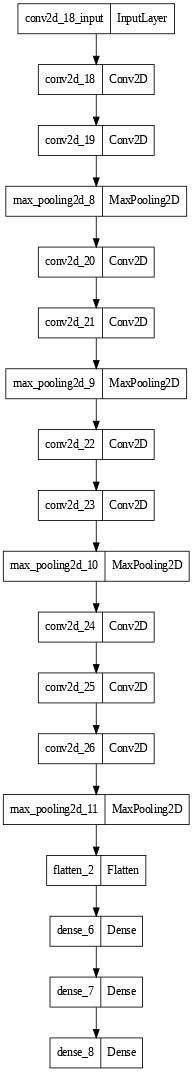

In [33]:
tf.keras.utils.plot_model(simple_model, dpi=60)

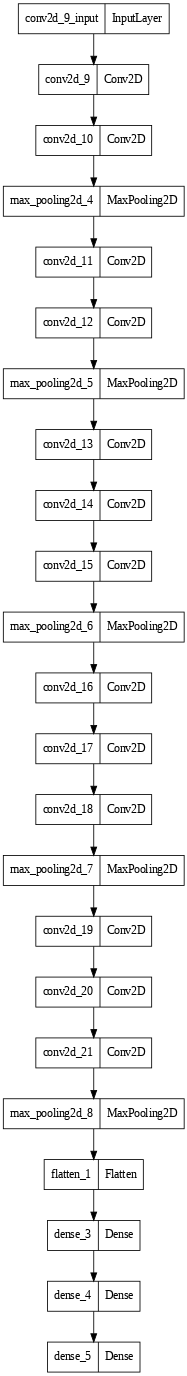

In [22]:
tf.keras.utils.plot_model(vgg16_model, dpi=60)

**Evaluations**

In [15]:
def evaluate(model, name='model'):
  loss, acc = model.evaluate(X_valid, y_valid, batch_size= batch)
  print(f"{name}'s accuracy: {round((acc * 100), 2)}%")

evaluate(simple_model, 'simple CNN')
evaluate(vgg16_model, 'VGG-16')

2/2 [==============================] - 12s 1s/step - loss: 0.1467 - accuracy: 0.9524
simple CNN's accuracy: 95.24%
2/2 [==============================] - 16s 5s/step - loss: 0.2679 - accuracy: 0.9735
VGG-16's accuracy: 97.35%


In [26]:
def predict(model):
  return np.argmax(model.predict(X_valid), axis=-1)

vgg16_comparison_list = list(zip(predict(vgg16_model), y_valid))
simple_comparison_list = list(zip(predict(simple_model), y_valid))
print("VGG-16 (predictions, true labels): ", vgg16_comparison_list)
print("simple model (predictions, true labels): ", simple_comparison_list)

6/6 [==============================] - 2s 152ms/step
VGG-16 (predictions, true labels):  [(1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (0, 1), (1, 1), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (0, 0), (1, 1)

Let's see where we made errors

In [27]:
def find_error_indices(comparison_list):
  err_list = []
  for i, pair in enumerate(comparison_list):
    index = i
    pred = pair[0]
    true = pair[1]
    if (true != pred):
      err_list.append((index, pred, true))
  return err_list

simple_model_errs = find_error_indices(simple_comparison_list)
vgg16_model_errs = find_error_indices(vgg16_comparison_list)

In [28]:
print(simple_model_errs)
print(vgg16_model_errs)

[(15, 0, 1), (28, 0, 1), (46, 0, 1), (79, 0, 1), (99, 1, 0), (129, 0, 1), (130, 0, 1), (137, 0, 1), (185, 0, 1)]
[(46, 0, 1), (62, 0, 1), (99, 1, 0), (130, 0, 1), (185, 0, 1)]


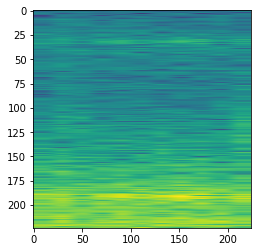

In [29]:
plt.imshow(X_valid[130])
plt.show()

In [30]:
from sklearn.metrics import f1_score

def get_f1_score(comparison_list):
  y_preds = [label[0] for label in comparison_list]
  y_true = [label[1] for label in comparison_list]
  return f1_score(y_true, y_preds)

print(f"VGG16 model's F1-score: {round((get_f1_score(vgg16_comparison_list) * 100), 2)}%") 
print(f"simple model's F1-score: {round((get_f1_score(simple_comparison_list) * 100), 2)}%") 

VGG16 model's F1-score: 97.67%
simple model's F1-score: 95.73%


###**XAI explanations**

In [16]:
!pip install lime --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=39e8ca965df0dbe11b1c482fee5d8e1f54231c83d8ed505107921fe776482e48
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [17]:
import lime
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [25]:
X_exp = []
count = 9
for i in range(count):
    print(y_valid[i])
    X_exp.append(X_valid[i])

X_exp = np.array(X_exp)
X_exp = X_exp.reshape(count, img_height, img_width, 3)

1
0
1
0
1
1
1
0
0


In [26]:
def explain_prediction(X):
  prediction = np.squeeze( simple_model.predict(X.reshape(1, img_height, img_width, 3)) )
  index = np.argmax(prediction)
  print(f"class {index} was predicted with the probablity of {prediction[index]}")

  explanation = explainer.explain_instance(X.reshape(img_height, img_width, 3).astype('double'), simple_model.predict, top_labels=2, hide_color=0, num_samples=800)
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
  explained_image = mark_boundaries(temp, mask)

  return explained_image, index, prediction[index] 

In [27]:
explanations = [explain_prediction(X_exp[i]) for i in range(0, count)]

1/1 [==============================] - 0s 17ms/step
class 1 was predicted with the probablity of 0.9564960598945618


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
class 0 was predicted with the probablity of 1.0


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
class 1 was predicted with the probablity of 0.9975276589393616


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
class 0 was predicted with the probablity of 0.9839186668395996


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step
class 1 was predicted with the probablity of 1.0


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step
class 1 was predicted with the probablity of 1.0


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
class 1 was predicted with the probablity of 0.9998937845230103


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
class 0 was predicted with the probablity of 0.9975462555885315


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step
class 0 was predicted with the probablity of 0.9999855756759644


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


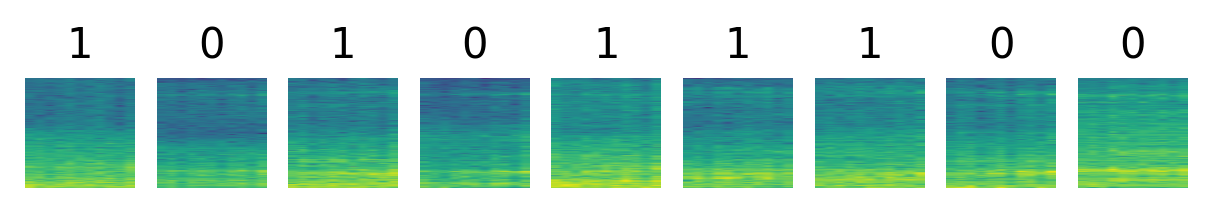

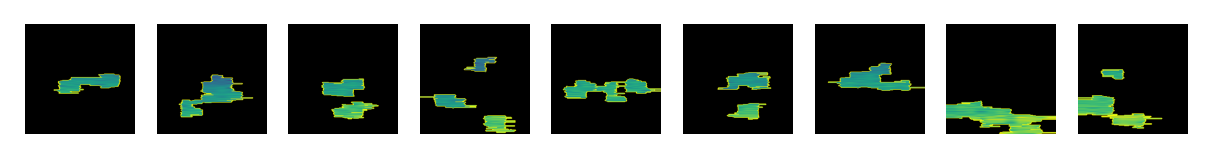

In [29]:
plt.figure(figsize=(6, 54), dpi=250)
for index, image in enumerate(explanations):
    plt.subplot(2, len(explanations), index+1)
    plt.title(f'{explanations[index][1]}')
    plt.imshow(X_exp[index])
    plt.axis("off")
plt.show()



plt.figure(figsize=(6, 48), dpi=250)
for index, image in enumerate(explanations):
    plt.subplot(2, len(explanations), index+1)
    plt.imshow(explanations[index][0])
    plt.axis("off")
plt.show()

1/1 [==============================] - 0s 36ms/step
class 1 was predicted with the probablity of 0.64675372838974


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
predicted 1 but is 0


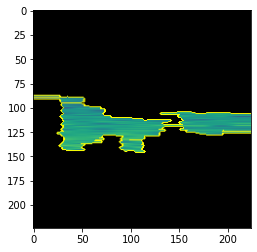

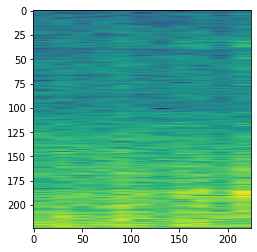

In [38]:
i = 99
mask, index, _ = explain_prediction(X_valid[i].reshape(1, img_height, img_width, 3))
print(f'predicted {index} but is {1 - index}')
plt.imshow(mask)
plt.show()
plt.imshow(X_valid[i])
plt.show()

1/1 [==============================] - 0s 16ms/step
class 0 was predicted with the probablity of 0.9536744356155396


  0%|          | 0/800 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step
predicted 0 but is 1


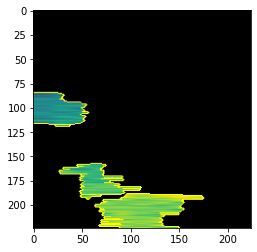

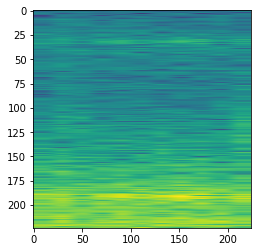

In [39]:
i = 130
mask, index, _ = explain_prediction(X_valid[i].reshape(1, img_height, img_width, 3))
print(f'predicted {index} but is {1 - index}')
plt.imshow(mask)
plt.show()
plt.imshow(X_valid[i])
plt.show()